<h1> HUB4045F Assignment 4  </h1>

### Ronak Mehta - MHTRON001 

In [3]:
# Import necessary packages
from __future__ import division
import pydicom as DCM
import trimesh
import cv2, numpy as np
from matplotlib import pyplot as plt, cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import procrustes
from skimage.draw import circle
%matplotlib inline

### Question 1 [10 marks]: Segmentation

Load dicom image provided {'CTimage.dcm'}. It is a crosss-sectional image slice from a CT volume which is taken around the mid femur region. It is common necessity to demarcate specific regions in such cross-sections in order to facilitate downstream quantification of anatomies (e.g. areas, moment of inertias)

a) Display the image **[1 mark]**

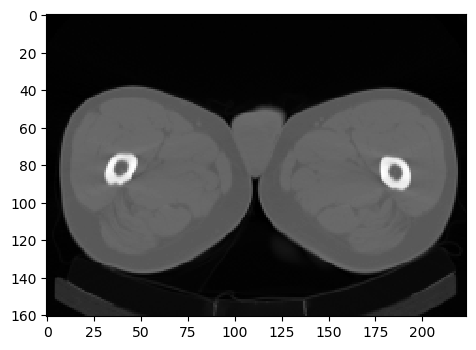

In [5]:
# read image file
dicom_image_file_0 = DCM.read_file('./CTimage.dcm')
I_ct = dicom_image_file_0.pixel_array

#Make a copy of the image
original = I_ct.copy()

# Get Rows and Columns 
nrows, ncols = I_ct.shape

#Plot the image
plt.figure(dpi=100)
plt.imshow(I_ct,'gray')

b) Isolate the leg on the left (white) **[3 marks]**



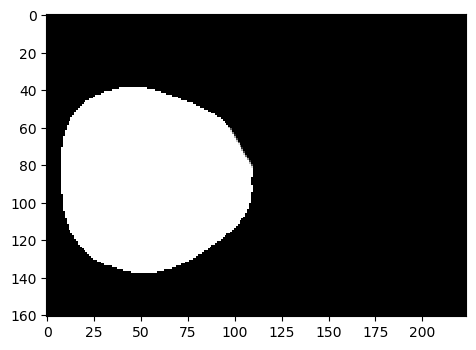

In [6]:
# Apply Histogram Equalization and normalization
I_ct_he = cv2.equalizeHist(cv2.convertScaleAbs(original))
I_ct_n = cv2.normalize(original,original,0,255,cv2.NORM_MINMAX) # rescale dynamic range: 0-255

# Apply Otsu's Threshold
ret, thresh = cv2.threshold(I_ct_he,0,1,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

mask = np.zeros(original.shape)
mask[:,:110] = 1 # initiating mask 1

#Apply mask 1
r1 = thresh * mask

# Rotate Mask 1
nrows, ncols = mask.shape
rotMtx = cv2.getRotationMatrix2D((ncols/2,nrows/2),30,1) # rotation matrix
rotMask = cv2.warpAffine(mask.copy(), rotMtx, (ncols,nrows)) # rotating mask

#Apply rotated mask
r2 = rotMask * r1

mask2 = np.zeros(original.shape)
mask2[70:95,25:50] = 1 # initiating mask

#Apply 2nd mask
r3 = 1-((1-r2)*(1-mask2))

#Apply color
r9 = cv2.merge((1*r3, 1*r3, 1*r3))

#Plot Image
plt.figure(dpi=100)
plt.imshow(r9, 'gray')

c) Segment and label the bone (yellow) **[3 marks]**



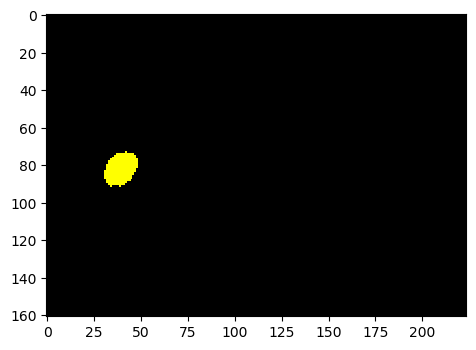

In [7]:
mask3 = np.zeros(original.shape)
mask3[70:95,25:50] = 1 # initiating mask

#Apply 3rd Mask
r4 = (1-r2)*(mask2)

mask4 = np.zeros(original.shape)
mask4[78:87,35:44] = 1 # initiating mask

#Apply 4th Mask
r5 = (1-(1-r4)*(1-mask4))

#Apply color
r6 = cv2.merge((1*r5, 1*r5, 0*r5))

#Plot Image
plt.figure(dpi=100)
plt.imshow(r6, 'gray')

d) segment and label the muscles (red) **[3 marks]**


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


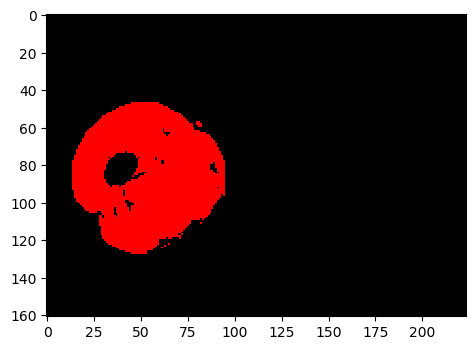

In [8]:
# Applying First Mask to Original Dicom Image
r7 = rotMask * original*mask

#Applying TOZERO thresholding to get muscle area
ret2, thresh2 = cv2.threshold(r7,92,255,cv2.THRESH_TOZERO)

#Create a circle to fit the desired region
r, c = circle(87,54,41)

mask5 = np.ones(original.shape) 
mask5[r,c] =0 #Initiating mask using circle

#Apply mask
thresh2[mask5>0] = 0
thresh2[r5>0]=0

#Apply color
r8 = cv2.merge((1*thresh2, 0*thresh2, 0*thresh2))

#Plot Image
plt.figure(dpi=100)
plt.imshow(r8, 'gray')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


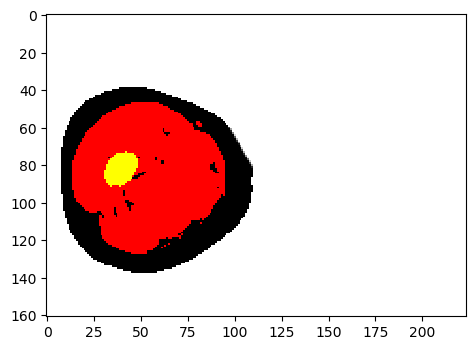

In [9]:
#Plot Image of Segmented Leg, Bone and Muscle
plt.figure(dpi=100)
plt.imshow(1-(r9-(r8+r6)), 'gray')

### Question 2 [10 marks]: Feature calculation

After segmenting the image into the necessary labelled regions, calculate the following metrics - 

a) Total area of the bone **[4 marks]**



In [10]:
#Get x and y Spacing in image
space = float(dicom_image_file_0.PixelSpacing[0])*float(dicom_image_file_0.PixelSpacing[1])

#Multiply sum of required area with the above spacing
bone_area = (r5>0).sum()*space

#Print Result
print('Total Bone Area in squared units = ', bone_area)

Total Bone Area in squared units =  8.705235154434002


b) Cortical area of the bone (i.e. only the high intensity region, ignoring the medullary region) **[3 marks]**



In [11]:
#Multiply sum of required area with the above spacing
Corticalbone_area = (r4>0).sum()*space

#Print Result
print('Cortical Bone Area in squared units = ', Corticalbone_area)

Cortical Bone Area in squared units =  7.365968207598001


c) Total muscle area **[3 marks]**


In [12]:
#Multiply sum of required area with the above spacing
muscle_area = (thresh2>0).sum()*space

#Print Result
print('Total Muscle Area in squared units = ', muscle_area)

Total Muscle Area in squared units =  157.78679265749403


### Question 3 [5 marks]: Import surfaces

Once image data has been labelled, some studies may require a comparison or study of the shape of the object (anatomy). Such an analysis can be done either in 2D or 3D depending on the domain of the source image(s) in the study. In 2D, shape is represented by contours. __In 3D, shape is typically represeted by triangular surface meshes. As an example the image volume that the above image slice is from, results in the displayed segmented image in 3D when all image slices are segmented__.

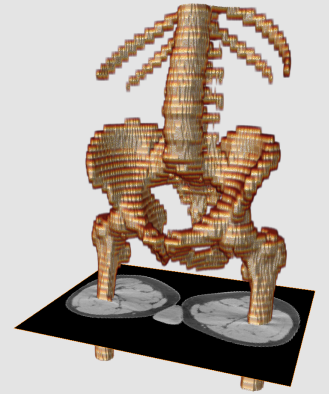 

Import 3D surface meshes of the two scapulae provided (Scapula1 & Scapula2) using any python library of your choice (you can try __[trimesh](https://pypi.org/project/trimesh/)__ or other such)

a) Display each mesh **[2 marks]**



In [13]:
# Load and Show Scapula1
mesh1 = trimesh.load('./Scapula1.ply')
mesh1.show()

In [14]:
# Load and show Scapula2
mesh2 = trimesh.load('./Scapula2.ply')
mesh2.show()

b) Speculate on requirements to compare the two 3D shapes. That is, what would correspondence mean in the context of surfaces? A mesh used to represent a surface is constituted of vertices (or nodes) that are points on the surface of the object. The topology of the mesh is described by an array (often called 'faces') that describes how the vertices are connected to each other. Thus, the relationship between 'vertices' is contained in 'faces'. If two surfaces, that are in correspondence, are described by the same mesh structure then they are 'iso-topological'. The two surfaces provided here are iso-topological where the vertices are in correspondence. That is, vertex id# describes the same anatomical location on both the surfaces. How many vertices does each surface have? How many faces? How would you confirm that they are indeed iso-topological? **[3 marks]**

##### Answer:
Both surfaces have 24168 vertices each. They also have 48332 faces each (Can be seen in the next cell).  

In [13]:
print(len(mesh1.faces), len(mesh2.faces), len(mesh1.vertices), len(mesh2.vertices))

48332 48332 24168 24168


In [14]:
print('mesh1 vertices = ', mesh1.vertices)
print('mesh2 vertices = ', mesh2.vertices)

mesh1 vertices =  [[465.3442688  284.93041992  69.39307404]
 [394.44152832 405.42227173 173.66003418]
 [393.67541504 386.48187256 122.45352173]
 ...
 [383.66345215 336.40835571  77.79823303]
 [418.20880127 375.48403931 171.53138733]
 [415.90390015 379.17214966 152.39614868]]
mesh2 vertices =  [[-432.3442688   307.8420105    87.14917755]
 [-383.85025024  382.11349487  103.77433777]
 [-382.29833984  381.3352356   105.46587372]
 ...
 [-422.23272705  332.27679443   91.84883881]
 [-425.60324097  339.62237549   85.38001251]
 [-410.10266113  381.37539673  169.6787262 ]]
